<ipython-input-3-62e68de3f9c0>:38: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 1470s 23s/step - accuracy: 0.2245 - loss: 2.7800 - val_accuracy: 0.2719 - val_loss: 7.7714
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1468s 23s/step - accuracy: 0.2684 - loss: 2.2694 - val_accuracy: 0.2719 - val_loss: 1.7750
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1463s 23s/step - accuracy: 0.3461 - loss: 1.9025 - val_accuracy: 0.3099 - val_loss: 1.5444
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1465s 23s/step - accuracy: 0.3467 - loss: 1.8687 - val_accuracy: 0.4708 - val_loss: 1.3441
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1467s 23s/step - accuracy: 0.3806 - loss: 1.6567 - val_accuracy: 0.4284 - val_loss: 1.4233
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1461s 22s/step - accuracy: 0.4348 - loss: 1.5469 - val_accuracy: 0.4006 - val_loss: 1.4422
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1453s 22s/step - accuracy: 0.4174 - loss: 1.5283 - val_accuracy: 0.2880 - val_loss: 1.6749
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1458s 22s/step - accuracy: 0.4719 - loss: 1.4122 - val_accuracy: 0.289

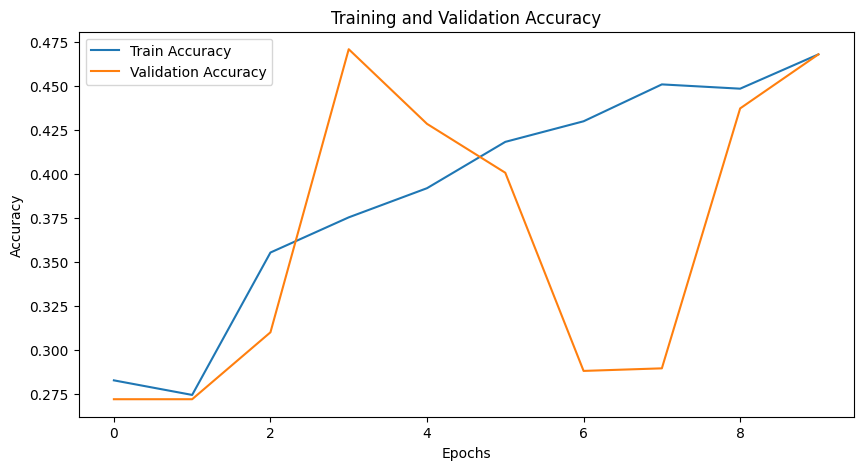

22/22 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


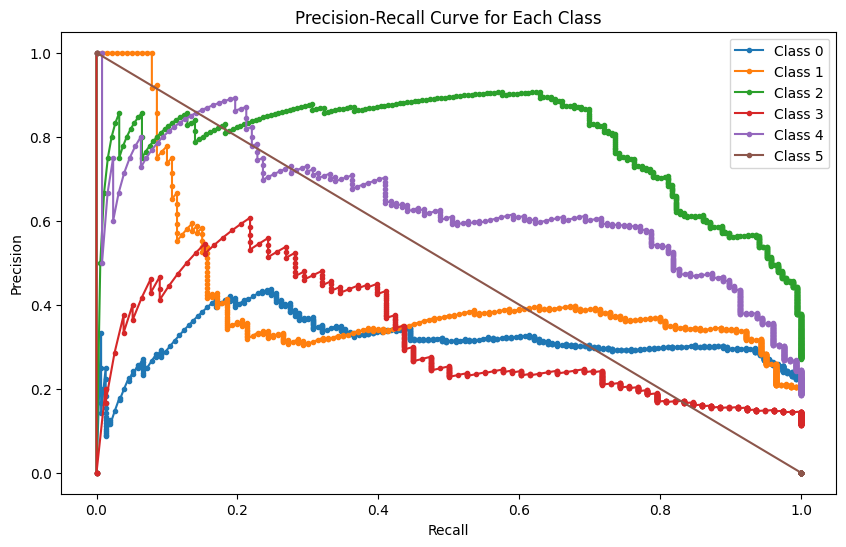

In [3]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.RandomResizedCrop(height=200, width=200, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

# Define image processing functions
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Expand dataset to 220 images per label
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        img = cv2.imread(img_path)
        augmented = augmentations(image=img)["image"]
        cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
        images.append(img_path)

# Apply Processing Techniques
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path)
        
        cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
        cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
        cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
        cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
        cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

# Split the dataset
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Compute class weights
class_weights = compute_class_weight(
    "balanced", classes=np.unique(all_labels), y=all_labels
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Set up data generators
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

# Define VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(len(valid_labels), activation='softmax')(x)

# Create and compile model
model = Model(inputs=base_model.input, outputs=out)
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight_dict
)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
num_classes = len(valid_labels)
y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()

